<h1 style="color: red">INCOMPLETE DRAFT: DO NOT PUBLICIZE. This document is being made open to facilitate collaboration before completion. Do not publicize it. Comments gratefully accepted.</h1>

# Classification of SARS-CoV-2 test results using consumer digital cameras: analysis of HNB-based colorimetry on RT-LAMP tests 

## by Andrew D. Straw, University of Freiburg, Faculty of Biology, <a href="mailto:straw@bio.uni-freiburg.de">straw@bio.uni-freiburg.de</a>

Hydroxy naphthol blue (HNB) is a dye that can be used in colorimetric assays to indicate the result of inexpensive LAMP-based diagnostic tests [(Goto et al., 2009)](https://doi.org/10.2144/000113072), including a rapid, and accurate test for SARS-CoV-2 using RT-LAMP [(Kellner et al. 2020)](https://doi.org/10.1101/2020.06.23.166397). Here we ask how to best use digital images of HNB-based SARS-CoV-2 tests. Ideally, image analysis could be completely automated such that reliable and robust classification of reaction results could be made by non-experts and would not require making subjective decisions on potentially subtle visual differences. Because the process is highly visual, experienced observers will be able to easily validate the automated processing steps.

Below, we use a computational analysis in Python to investigate the use of colorimetry on images from standard consumer digital cameras with the goal of incorporating image acquisition and automated analysis as a part of a reliable, robust, inexpensive and easy to use SARS-CoV-2 testing system with with a minimum of equipment.

The overall approach is to use spectral absorbance curves of HNB [(Goto et al., 2009)](https://doi.org/10.2144/000113072) as the basis of to predicting HNB appearance as a function of LAMP test status. In the course of a positive LAMP reaction, Mg2+ concentration in solution changes from high to low and, correspondingly, the visible appearance of the test result changes from violet to sky blue. However, these appearance changes are subjective and may be subtle for inexperienced observers.

While Goto et al. 2009 noted that the visual appearance (the color) of HNB changed with Mg2+ concentration, their quantification method was to measure absorption at a single wavelength (650 nm). Here, we are interested in using a digital image sensor from a consumer camera to perform classification into "positive" vs "negative". While narrow-band quantification is not possible with a consumer camera, here we address the question of whether a comparison of intensity between the image color channels can be used to quantify Mg2+ concentration and thus classify the result of a test as positive or negative. Ideally, variation in illumination source, visual background, and digital camera manufacturer and model will have negligible effect on the outcome of the automated image processing.

Below we use spectral response properties of a digital image sensor (the Sony IMX219) and the spectrum of simulated sunlight as representative of real world consitions.

Based on [Goto et al. (2009)](https://doi.org/10.2144/000113072) and  [(Kellner et al. 2020)](https://doi.org/10.1101/2020.06.23.166397), we expect positive test results to be sky blue because much DNA is polymerized in the RT-LAMP reaction and Mg2+ concentration drops. Negative test results will be violet due to high Mg2+ concentration in solution.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import skimage.color

In [2]:
skimage.color.rgb2hsv

<function skimage.color.colorconv.rgb2hsv(rgb)>

In [3]:
# Load absorbance curves of HNB.

# Data from Goto et al. 2009, digitized with WebPlotDigitizer https://apps.automeris.io/wpd/
hnb_Mg_0mM = pd.read_csv("hnb_Mg_0mM.csv",names=["wavelength","Absorbance, HNB, Mg2+ 0 mM"], index_col=0)
hnb_Mg_4mM = pd.read_csv("hnb_Mg_4mM.csv",names=["wavelength","Absorbance, HNB, Mg2+ 4 mM"], index_col=0)
hnb_Mg_7mM = pd.read_csv("hnb_Mg_7mM.csv",names=["wavelength","Absorbance, HNB, Mg2+ 7 mM"], index_col=0)
hnb_Mg_8mM = pd.read_csv("hnb_Mg_8mM.csv",names=["wavelength","Absorbance, HNB, Mg2+ 8 mM"], index_col=0)

In [4]:
# Merge all dataframes according to wavelength and interpolate

absorbance_df = pd.merge_ordered(left=hnb_Mg_0mM, right=hnb_Mg_4mM, on='wavelength')
absorbance_df = pd.merge_ordered(left=absorbance_df, right=hnb_Mg_7mM, on='wavelength')
absorbance_df = pd.merge_ordered(left=absorbance_df, right=hnb_Mg_8mM, on='wavelength')

absorbance_df.set_index('wavelength',inplace=True)
absorbance_df.interpolate(inplace=True, method='index', limit_area='inside')

In [5]:
# Convert absorbance to transmittance and put in new DataFrame `df`.

def convert(colname, indf):
    absorbance = indf[colname]
    col = np.power(10.0,-absorbance.values)
    a = "Absorbance, "
    assert colname.startswith(a)
    b = colname[:]
    b = b[len(a):]
    return b, col

data = {}
for colname in absorbance_df.columns:
    new_name, col = convert(colname, absorbance_df)
    data[new_name] = col
data['wavelength'] = absorbance_df.index
df = pd.DataFrame(data)
del data

In [6]:
# Load camera curves.

# Data from https://raw.githubusercontent.com/khufkens/pi-camera-response-curves/master/Sony_IMX219_spectral_response.csv
camera = pd.read_csv("Sony_IMX219_spectral_response.csv", index_col=0)
camera.index = camera.index.astype(float)
camera /= 100.0

In [7]:
# Merge absorbance data with camera data according to wavelength and interpolate
df = pd.merge_ordered(left=df, right=camera, on='wavelength')

df.set_index('wavelength',inplace=True)
# df.interpolate(inplace=True)
df.interpolate(inplace=True, method='index', limit_area='inside')

In [8]:
# Black body spectrum (Planck's Law). This simulates sunlight at about 5800K.

# Modified from https://github.com/axr6077/ParticleTrajectory/blob/dce4e5ee9f1492ccc4816632c7dbf0d47651e7e6/Python%20Scripts/spectrum.py
def black_body(wavelengths, T):
    from scipy.constants import h, c, k

    l = wavelengths * 1e-9
    energy_density = 2 * h * c ** 2 / l ** 5 * 1.0 / (np.exp(h * c / (l * k * T)) - 1.0)
    energy_density /= np.max(energy_density)
    return energy_density

In [9]:
# Calculate sunlight spectrum
df["5800K"] = black_body(df.index.values,5800)

<IPython.core.display.Javascript object>


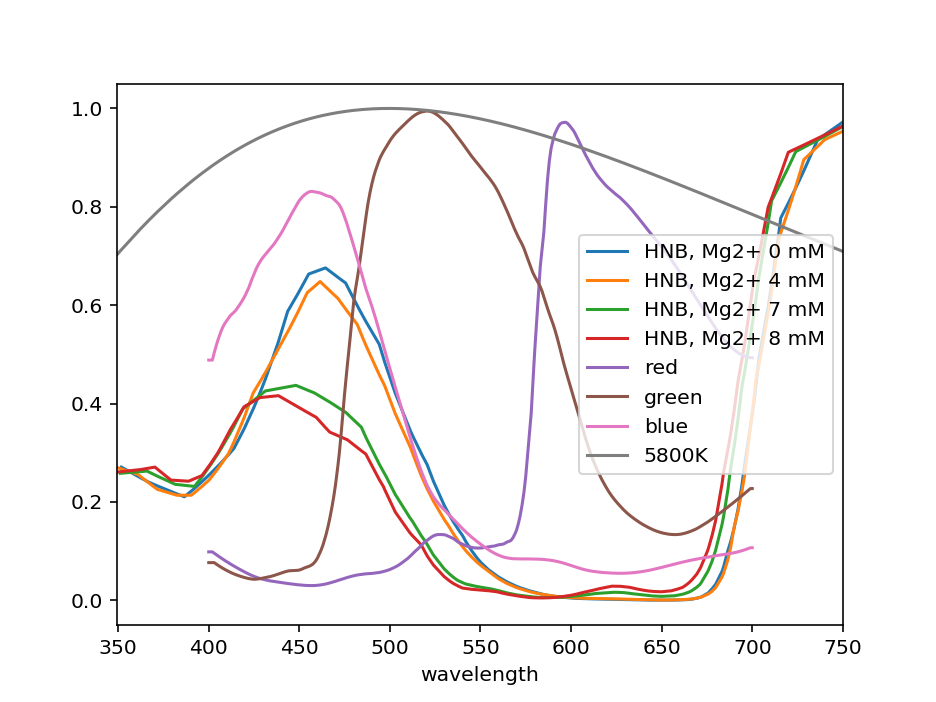

In [10]:
# As a sanity check, let's plot our spectra. Unfortunately, with this simple 
# one-line plot command, we cannot easily assign relevant colors to the lines.
df.plot();

In [11]:
# Reindex to ensure uniform spacing along wavelengths.
df = df.reindex(np.arange(350, 750))

In [12]:
# Calculate quantum catch of each color channel for each concentration.

mg0 = []
mg4 = []
mg7 = []
mg8 = []
for channel in ["red","green","blue"]:
    mg0.append((df["HNB, Mg2+ 0 mM"]*df["5800K"]*df[channel]).sum())
    mg4.append((df["HNB, Mg2+ 4 mM"]*df["5800K"]*df[channel]).sum())
    mg7.append((df["HNB, Mg2+ 7 mM"]*df["5800K"]*df[channel]).sum())
    mg8.append((df["HNB, Mg2+ 8 mM"]*df["5800K"]*df[channel]).sum())

In [13]:
# Display RGB values for the difference concentrations. Note
# that there is an overall scale here which isn't defined.
display(mg0)
display(mg4)
display(mg7)
display(mg8)

[5.424809828386763, 27.2852637448521, 39.457711205885644]

[5.093522303978644, 24.577634892693, 37.443973155773705]

[5.979991787233921, 15.117263777166263, 27.82071051225431]

[7.067465298544235, 13.552051591985796, 25.700069449101907]

In [14]:
# Here we see that, independent of scale factor in RGB space, the hue and saturation remain constant.
ts = np.array([mg0,mg4,mg7,mg8])
ts.shape = (1,4,3)
display(skimage.color.rgb2hsv(ts))
display(skimage.color.rgb2hsv(ts*10))

array([[[ 0.55961118,  0.86251585, 39.45771121],
        [ 0.56628624,  0.8639695 , 37.44397316],
        [ 0.59694008,  0.78505251, 27.82071051],
        [ 0.60866273,  0.72500209, 25.70006945]]])

array([[[  0.55961118,   0.86251585, 394.57711206],
        [  0.56628624,   0.8639695 , 374.43973156],
        [  0.59694008,   0.78505251, 278.20710512],
        [  0.60866273,   0.72500209, 257.00069449]]])

<IPython.core.display.Javascript object>


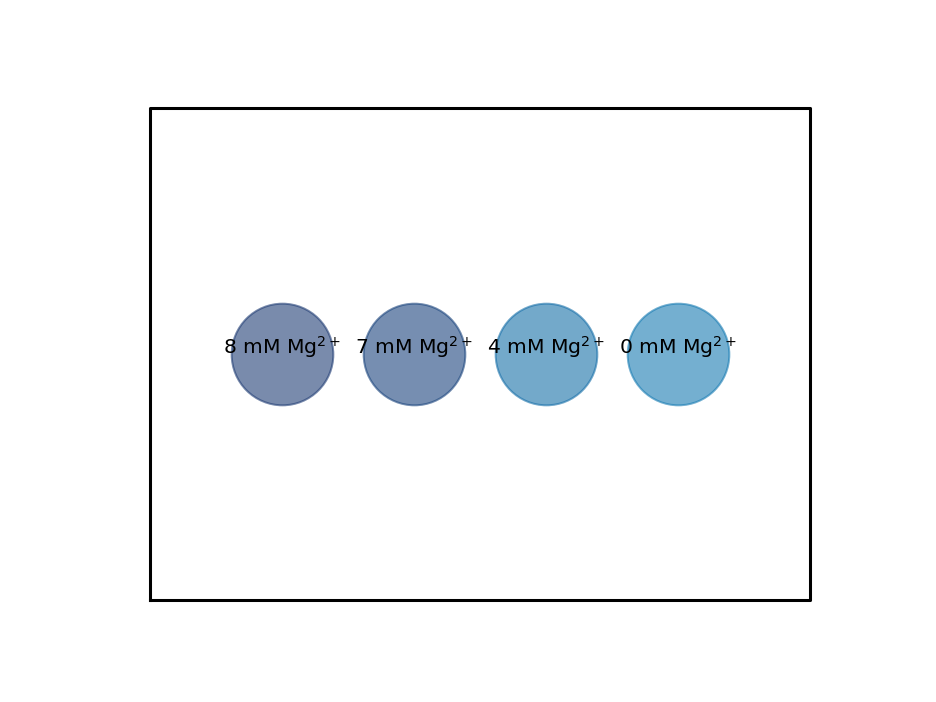

In [15]:
# Scale: first term to make brighter, second term to put in interval (0,1) as a float.
scale = 4.5/255.0
markersize=50.0
alpha = 0.6

fig, ax = plt.subplots(frameon=False)

ax.plot([0.4],[0.1],marker='o',markersize=markersize,color=np.array(mg0)*scale,alpha=alpha)
ax.text(0.4,0.1,'0 mM Mg$^{2+}$',horizontalalignment='center')

ax.plot([0.3],[0.1],marker='o',markersize=markersize,color=np.array(mg4)*scale,alpha=alpha)
ax.text(0.3,0.1,'4 mM Mg$^{2+}$',horizontalalignment='center')

ax.plot([0.2],[0.1],marker='o',markersize=markersize,color=np.array(mg7)*scale,alpha=alpha)
ax.text(0.2,0.1,'7 mM Mg$^{2+}$',horizontalalignment='center')

ax.plot([.1],[0.1],marker='o',markersize=markersize,color=np.array(mg8)*scale,alpha=alpha)
ax.text(.1,0.1,'8 mM Mg$^{2+}$',horizontalalignment='center')

ax.plot([0.0, 0.5, 0.5, 0.0, 0.0],[0.0, 0.0, 0.2, 0.2, 0.0],'k-')

ax.axis('off');

![Goto-et-al-2009-Fig1.png](Goto-et-al-2009-Fig1.png)
Figure: visual appearance and absorption spectrum of HNB, from [Goto et al. (2009)](https://doi.org/10.2144/000113072).

- Tube a: 8 mM Mg2+ ions, no dNTPs, pH 8.6–9.0.
- Tube b: 8 mM Mg2+ ions, 1.4 mM dNTPs, pH insensitive, red line in spectrum
- Tube c: 7 mM Mg2+ ions, 1.4 mM dNTPs, pH insensitive, cyan line in spectrum
- ...
- Tube f: 4 mM Mg2+ ions, 1.4 mM dNTPs, pH insensitive, green line in spectrum
- Tube g: 0 mM Mg2+ ions, 1.4 mM dNTPs, pH insensitive, black line in spectrum

## Comparing our prediction with a real digital image.

Let's compare the prediction above with a real digital image of HNB with varying Mg2+ concentration.

![Kellner-2020-Fig5D.png](Kellner-2020-Fig5D.png)

Photo from: A rapid, highly sensitive and open-access SARS-CoV-2 detection assay for laboratory and home testing
Max J. Kellner, James J. Ross, Jakob Schnabl, Marcus P.S. Dekens, Robert Heinen, Irina Grishkovskaya, Benedikt Bauer, Johannes Stadlmann, Luis Menéndez-Arias, Robert Fritsche-Polanz, Marianna Traugott, Tamara Seitz, Alexander Zoufaly, Manuela Födinger, Christoph Wenisch, Johannes Zuber, Vienna Covid-19 Diagnostics Initiative (VCDI), Andrea Pauli, Julius Brennecke
bioRxiv 2020.06.23.166397; doi: https://doi.org/10.1101/2020.06.23.166397 
